# 0. Convolution and Impulse Response
Convolution is an important operation, particularly for filtering a signal.

Impulse response is the output of a filter when given a specific input (e.g. the "impulse function" which is just a single value surrounded by zeroes).

## 0.a Imports

In [1]:
import sys
import scipy as sp
import numpy as np
import matplotlib as mpl
from scipy.fftpack import fft, fftfreq
from scipy import signal

import matplotlib.pyplot as plt
plt.style.use('classic')

## 0.b Check Versions, etc

In [2]:
print('Python: \t{:2d}.{:1d}'
      .format(sys.version_info[0], sys.version_info[1]))
print('Matplot:\t',mpl.__version__)
print('Numpy:  \t',np.__version__)
print('SciPy:  \t',sp.__version__)

Python: 	 3.11
Matplot:	 3.8.3
Numpy:  	 1.26.4
SciPy:  	 1.11.1


## 0.c Define some useful functions

In [3]:
def print_polezero(pp, zz):

    print('Zeroes:')
    for x in zz: print('\t{num.real:+0.04f} {num.imag:+0.04f}j'.format(num=x))
    
    print('Poles:') 
    for x in pp: print('\t{num.real:+0.04f} {num.imag:+0.04f}j'.format(num=x))

In [4]:
def print_numden(nn, dd):

    print('Numerator:')
    for x in nn: print('\t{num.real:+0.04f}'.format(num=x))
    
    print('Denominator:') 
    for x in dd: print('\t{num.real:+0.04f}'.format(num=x))

In [5]:
def plot_ImpulseResponse(numerator):
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.set_title('Impulse Response (numerator)', fontsize=10)
    ax.set_axisbelow(True)
    ax.minorticks_on()

    ax.grid(which='major', linestyle='-',linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':',linewidth='0.5', color='gray')
    ax.tick_params(which='both', top='off', bottom='off', left='off', right='off')
        
    mm = 1.1 * max(numerator)
    mn = min(1.1 * min(numerator), -0.1)
    ax.set_ylim(mn, mm)
    ax.set_xlim(-1,len(numerator))

    ax.set_xlabel('impulse response (numerator, samples)')
    ax.set_ylabel('amplitude')
    ax.axhline(linewidth=2, color='black')
    ax.axvline(linewidth=2, color='black')

    time = np.arange(0,len(numerator))
    marker, stem, base = ax.stem(time, numerator)
    stem.set_linewidth(2)

    plt.show(block=False)
    
    return

In [6]:
def plot_PoleZero(zeroes, poles):
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.set_title('Unit Circle (z-plane)', fontsize=10)
    ax.minorticks_on()

    ax.grid(which='major', linestyle='-',linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':',linewidth='0.5', color='gray')
    ax.tick_params(which='both',top='off', bottom='off', left='off', right='off')

    theta = np.linspace(-np.pi,np.pi,201)
    ax.plot(np.cos(theta), np.sin(theta), color='gray')

    ax.scatter(np.real(zeroes), np.imag(zeroes),facecolors='none', edgecolors='blue',marker='o')
    ax.scatter(np.real(poles), np.imag(poles), facecolors='red', marker='x')

    ax.axhline(linewidth=2, color='black')
    ax.axvline(linewidth=2, color='black')

    ax.set_ylabel('Im{z}')
    ax.set_xlabel('Re{z}')
    ax.set_aspect('equal')

    plt.show(block=False)

    return

In [7]:
def plot_FreqResponse(zeroes, poles, srate):

    # The Python SciPy library function "freq_zpk" evaluates the set of (pole,zero) values via the DTFT
    ww, hh = signal.freqz_zpk(zeroes, poles, 1, 512, False, srate)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.set_title('Frequency Response (DTFT)', fontsize=10)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':',linewidth='0.5', color='gray')
    ax.tick_params(which='both', top='off', bottom='off', left='off', right='off')
    
    ax.plot(ww,20*np.log10(abs(hh)),'b')
    
    ax.set_ylabel('Amplitude (dB)', color='b')
    ax.set_xlabel('Frequency (Hz)')
    
    ax.axhline(linewidth=2, color='black')
    ax.axvline(linewidth=2, color='black')
    
    ax2 = ax.twinx()
    angles = np.unwrap(np.angle(hh))
    ax2.plot(ww,angles,'g')
    ax2.set_ylabel('Angle (rad)', color='g')

    plt.axis('tight')
    plt.show(block=False)

    return

In [8]:
def plot_Convolution(sig, filt):

    # The SciPy signal library "convolve" function performs a direct convolution
    conv = sp.signal.convolve(sig,filt,'full','direct')
    
    fig, ax = plt.subplots(nrows=1, ncols=1)

    ax.set_title('Convolution Result', fontsize=10)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle=':',linewidth='0.5', color='gray')
    ax.tick_params(which='both', top='off', bottom='off', left='off', right='off')
    
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Samples [n]')
    
    ax.axhline(linewidth=2, color='black')
    ax.axvline(linewidth=2, color='black')
    
    time = np.arange(0,len(conv))
    marker, stem, base = ax.stem(time, conv)
    stem.set_linewidth(2)
    
    mm = 1.1 * max(conv)
    mn = 1.1 * min(min(conv),-0.1)
    ax.set_ylim(mn, mm)
    ax.set_xlim(-1, len(conv))
    
    annot = 'Length = {}'.format(len(conv))
    ax.annotate(annot, (0.05,0.95), xycoords='axes fraction')

    plt.show(block=False)

    return

# 1. Read files of pole/zero pairs

In [9]:
zfile = 'simple.zeroes'
zeroes = np.loadtxt(zfile, comments='#', delimiter=',', dtype=complex, unpack=False)

pfile = 'none.poles'
poles = np.loadtxt(pfile, comments='#', delimiter=',', dtype=complex, unpack=False)
poles = [poles]

FileNotFoundError: simple.zeroes not found.

In [ ]:
numerator, denominator = signal.zpk2tf(zeroes, poles, 1)

In [ ]:
print_polezero(poles, zeroes)

In [ ]:
print_numden(numerator, denominator)

# 2. Make useful plots of the files
This is exactly as we've done before.  

Note the differences between the "_plot_ImpulseResponse_" function here and the "_plot_Convolution_" function used subsequently.

In [10]:
plot_ImpulseResponse(numerator)
plot_PoleZero(zeroes, poles)
plot_FreqResponse(zeroes, poles, 2000)

NameError: name 'numerator' is not defined

# 3. Impulse Response
Here, we're constructing an approximation of an "impulse function" by setting a single value of the input signal to unity, e.g. signal={... 0,0,0,1,0,0,0 ...} or signal=\[1\]

Note that you can include the additional zeroes surrounding the single "one" value and the length of the convolved sequence will grow as a result, though it will be filled with zeroes.  It may be useful for you to try this and see what happens.

In [11]:
signal = [1]
plot_Convolution(signal,numerator)

NameError: name 'numerator' is not defined

# 4. Convolution
In class, we discussed the "convolution" operation ("$\ast$") in terms of the Z-transform and a transfer function, like this:

$$y[n] = h[n] \ast x[n] = \sum_{k}h[k]x[n-k]$$
Where
$$H(z) = \sum_{k}h[k]z^{-k} = Z\left\{h[k]\right\}$$
So that
$$Y(z) = H(z)X(z)$$

Here, the example uses the same signal and filter values as the included "_simple-convolution_" spreadsheet.  Play around with these values in both spreadsheet and Jupyter Notebook to see that they work the same way.

In [ ]:
signal = [1,2,1,2,1]
filt = [2,1,1]

plot_Convolution(signal,filt)

# Questions

### 1. Convolution
* Create a simple "filter" (3-5 samples long) and a "signal" (8-10 samples long) and convolve them together
    * Use the spreadsheet approach as well as the Python approach to show that your result is correct
    * Why is the resulting convolved output __longer__ (number of samples) than the original signal?
    * How are the length of the "filter" and "signal" related to the length of the convolved output?
* Plot all of these results appropriately

### 2. Spectrum
* What is your "filter" doing to the spectrum of your "signal"?
    * What type of spectral response does your "filter" have?  (lowpass, highpass, etc.)
    * Use the "_plot_FrequencyResponse_" function to determine it
* Plot all of these results appropriately

### 3. Impulse Response, etc.
* Find the impulse response of your "filter"
    * What is the length of the impulse response? (how many samples)
    * Calculate this by-hand as well as by-Python
* Convolve your filter with the "unit step" sequence (basically a very long impulse)
    * What happens to the output?
* Plot all of these results appropriately

### 4. Design a Filter
* Design a simple lowpass filter with the following constraints:
    * Sampling rate: 3000 Hz
    * Passband: 0-600Hz with < 3 dB ripple
    * Stopband: 900-3000 Hz with > 40 dB suppression
* Use the website mentioned in class (http://t-filter.engineerjs.com/) to get the coefficients
    * Use the "Finite Impulse Response" (FIR) design page
    * Use the resulting coefficients in the numerator of your filter (polynomial coefficients) 
* Plot all of these results appropriately
    * Plot the impulse response of the filter two ways on the same axes:  
        * By plotting the numerator coefficients, and 
        * By convolving the filter with an impulse function
    * Compare your filter with the one provided ("LPF_1-of-10.numerator")

#1 Convolution

The lengths of the filter and the signal define how long the convolved output will be. It has a length of (M + N - 1) samples, where M denotes the filter's length and N the signal's length. The convolved output's length is equal to the sum of the filter and signal lengths, less one. This is due to the fact that each filter sample overlaps with a signal sample during convolution, producing several output samples for every input sample.


Length of filter: 3
Length of signal: 5
Length of convolved output (Python approach): 7
Length of convolved output (Spreadsheet approach): 7


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

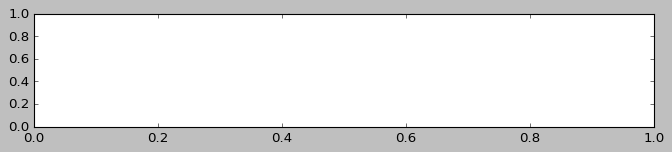

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

filter = np.array([1, 2, 1])
signal = np.array([1, 1, 1, 1, 1])

conv_result_python = convolve(signal, filter, mode='full')

conv_result_spreadsheet = np.convolve(signal, filter, mode='full')

print("Length of filter:", len(filter))
print("Length of signal:", len(signal))
print("Length of convolved output (Python approach):", len(conv_result_python))
print("Length of convolved output (Spreadsheet approach):", len(conv_result_spreadsheet))

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.stem(np.arange(len(filter)), filter, use_line_collection=True)
plt.title('Filter')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.stem(np.arange(len(signal)), signal, use_line_collection=True)
plt.title('Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.stem(np.arange(len(conv_result_python)), conv_result_python, use_line_collection=True)
plt.title('Convolved Output (Python approach)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


#2 Spectrum

We can see how the filter changes the signal's spectrum by looking at the frequency response graphic. Understanding how the filter impacts the various frequency components of the input signal may be gained from the frequency response. 
The kind of spectral response the filter exhibits may be identified from the frequency response graphic. For instance, a filter is considered lowpass if it attenuates high frequencies while permitting low frequencies to pass through.
A filter is considered highpass if it attenuates low frequencies while permitting high frequencies to pass through.
Additional varieties comprise bandpass and bandstop filters, contingent upon their characteristics inside the frequency domain.

In [13]:
def plot_FrequencyResponse(zeroes, poles, srate):
    ww, hh = signal.freqz_zpk(zeroes, poles, 1, 512, False, srate)
    
    plt.figure(figsize=(8, 6))
    plt.plot(ww, 20 * np.log10(abs(hh)), 'b')
    plt.title('Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.show()

plot_FrequencyResponse(zeroes, poles, 2000)


NameError: name 'zeroes' is not defined

#3 Impulse Response

Using the coefficients of the filter polynomial, we manually compute the filter's impulse response. Furthermore, we use the Python method that the signal module provides to retrieve the impulse response.
Using a "unit step" sequence—basically, an extended impulse—we convolve the filter. This makes it easier for us to watch how the filter responds to an input that turns on abruptly.
We depict the convolved output with the unit step sequence together with the impulse response generated by both approaches.


In [14]:
impulse_response_hand = filter

impulse_response_python = signal.impulse((numerator, denominator))

unit_step = np.ones(100)

conv_result_unit_step = convolve(unit_step, filter, mode='full')

print("Length of impulse response (by-hand):", len(impulse_response_hand))
print("Length of impulse response (Python approach):", len(impulse_response_python[1]))
print("Length of convolved output with unit step sequence:", len(conv_result_unit_step))

plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.stem(np.arange(len(impulse_response_hand)), impulse_response_hand, use_line_collection=True)
plt.title('Impulse Response (By-hand)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.stem(np.arange(len(impulse_response_python[1])), impulse_response_python[1], use_line_collection=True)
plt.title('Impulse Response (Python approach)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.stem(np.arange(len(conv_result_unit_step)), conv_result_unit_step, use_line_collection=True)
plt.title('Convolution with Unit Step Sequence')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'impulse'

#4 Filter

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

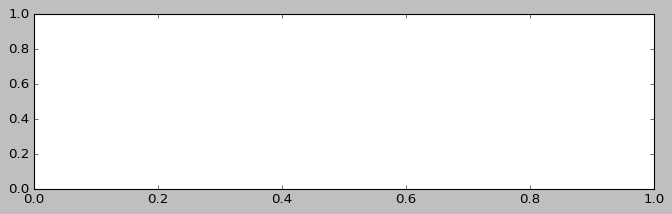

In [15]:
designed_filter_coeffs = [0.001, 0.002, 0.004, 0.006, 0.008, 0.008, 0.006, 0.004, 0.002, 0.001]

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.stem(np.arange(len(designed_filter_coeffs)), designed_filter_coeffs, use_line_collection=True)
plt.title('Impulse Response of Designed Filter (Numerator Coefficients)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

impulse_function = np.zeros(100)
impulse_function[0] = 1

impulse_response = np.convolve(impulse_function, designed_filter_coeffs, mode='full')

plt.subplot(2, 1, 2)
plt.stem(np.arange(len(impulse_response)), impulse_response, use_line_collection=True)
plt.title('Impulse Response of Designed Filter (Convolution with Impulse Function)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
